<img src='./img/header_placeholder.png' alt='Logo EU Copernicus ECMWF' align='right' width='100%'></img>

<br>

# CAMS global reanalysis (EAC4) monthly averaged fields

### About

This notebook provides you a practical introduction to the CAMS Global reanalysis (EAC4) data set. We will use the monthly averaged fields to analyse the distribution of Carbon Monoxide in the northern hemisphere and at different vertical layers in the atmosphere for August 2020. Carbon Monoxide is a colorless, odorless gas exisiting in the atmosphere, which is produced by burning (combustion) of fossil fuels (coal, oil and natural gas) and biomass (for example, woood in forest fires).

The notebook has the following outline:

* [1 - Unzip the downloaded data files](#cams_unzip)
* [2 - Load the data with xarray](#eac4_load)
* [3 - Compute meridional mean plot of Carbon Monoxide](#eac4_meridional_mean)
* [4 - Visualize the meridional mean plot of Carbon Monoxide in August 2020](#eac4_visualize)

### Data

This notebook introduces you to the CAMS global reanalysis (EAC4) monthly averaged fields. The data has the following specifications:

> **Data**: `CAMS global reanalysis (EAC4) monthly averaged fields` <br>
> **Temporal coverage**: `Aug 2020` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `zipped NetCDF files`<br>
> **Retrieve request**: [CDS API request](./200_atmosphere_data_store_intro.ipynb#eac4_monthly)

Get [here](./201_cams_data_intro.ipynb) more information about the CAMS global reanalysis data in general.

### How to access the notebook
* via [nbviewer](https://github.com/ecmwf-projects/copernicus-training/blob/master/111_c3s_climatologies_anomalies.ipynb): view a static version of the notebook 
* via [Binder](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training/HEAD?urlpath=lab/tree/111_c3s_climatologies_anomalies.ipynb): run, execute and modify the notebook

<hr>

### Load libraries

In [17]:
# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

<hr>

## <a id='cams_unzip'></a>1. Unzip the downloaded data files

The Atmosphere Data Store allows you to choose between two data formats, `GRIB` and `NetCDF`. However, the data is archived in `zip` file when downloaded. For this reason, before we can load any data, we have to unzip the files. Once you downloaded the data as a zip file (see CDSAPI request [here](./200_atmosphere_data_store_intro.ipynb#eac4_monthly)), you can use the functions from the `zipfile` Python package to extract the content of a zip file. First, you construct a `ZipFile()` object and second, you apply the function `extractall()` to extract the content of the zip file.

In [5]:
import zipfile
with zipfile.ZipFile('./data/cams_eac4_202008_pl.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/cams/')

<br>

## <a id='eac4_load'></a>2. Load the data with xarray

From the zip archive, two `NetCDF` files are extracted: one with the name ending `_pl`, which contains the CO values on the chosen pressure levels and one with the name ending `_ml`, which contains the CO values on the surface. Since we are interested in the vertical distribution of CO in the northern hemisphere in August 2020, we want to load the file containing CO values on different pressure levels.

You can use the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `open_dataset` to read a NetCDF file. The result is a `xarray.Dataset` with four dimensions: `latitude`, `level`, `longitude`, `time`.

In [23]:
ds_co = xr.open_dataset('./data/cams/levtype_pl.nc')
ds_co

<xarray.Dataset>
Dimensions:    (latitude: 241, level: 15, longitude: 480, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * level      (level) int32 100 150 200 250 300 400 ... 850 900 925 950 1000
  * time       (time) datetime64[ns] 2020-08-01
Data variables:
    co         (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-09-14 14:57:36 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

The next step is to extract the data variable `co`. You can extract a data variable as `xarray.DataArray` by specifying the name of the variable in square brackets. The loaded data array reveals additional attributes of the variable, such as `units` and `long_name`. 

In [24]:
da_co = ds_co['co']
da_co

<xarray.DataArray 'co' (time: 1, level: 15, latitude: 241, longitude: 480)>
[1735200 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * level      (level) int32 100 150 200 250 300 400 ... 850 900 925 950 1000
  * time       (time) datetime64[ns] 2020-08-01
Attributes:
    units:          kg kg**-1
    long_name:      Carbon monoxide
    standard_name:  mass_fraction_of_carbon_monoxide_in_air

<br>

If you have a closer look at the longitude values in the data array above, you see that the CAMS global reanalysis data are on a [0, 360] grid. Let us bring the longitude values to a [-180, 180] grid. You can use the xarray function `assign_coords()` to do so.

If you inspect the longitude values after the operation, you see that the values now range from -180 to 180.

In [25]:
da_co_assigned = da_co.assign_coords(longitude=(((da_co.longitude + 180) % 360) - 180)).sortby('longitude')
da_co_assigned

<xarray.DataArray 'co' (time: 1, level: 15, latitude: 241, longitude: 480)>
[1735200 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * level      (level) int32 100 150 200 250 300 400 ... 850 900 925 950 1000
  * time       (time) datetime64[ns] 2020-08-01
Attributes:
    units:          kg kg**-1
    long_name:      Carbon monoxide
    standard_name:  mass_fraction_of_carbon_monoxide_in_air

<br>

## <a id='eac4_meridional_mean'></a>3. Compute meridional mean plot of Carbon Monoxide

The next step is now to prepare the data in order to create a meridional mean plot to visualise the changing concentrations of CO at different longitudes and at various levels of the atmosphere. We will focus on the northern hemisphere and average over the latitudinal axis. This allows us to visualise a two dimensional plot of CO concentrations by longitude and altitude.

The first step is to filter all data values over the northern hemisphere. The xarray function `where()` allows us to filter any dimension of a data array. Let us filter the array and keep only data where the latitude dimension is positive. You can specify the keyword argument `drop`, which drops the values that were filtered out by the operation.

The size of the latitude dimension of the resulting data array has decreased by half, from 241 to 121 grid points.

In [42]:
north = da_co_assigned.where((da_co_assigned.latitude >= 0), drop=True)
north

<xarray.DataArray 'co' (time: 1, level: 15, latitude: 121, longitude: 480)>
array([[[[1.9785602e-08, 1.9785602e-08, 1.9785602e-08, ...,
          1.9785602e-08, 1.9785602e-08, 1.9785602e-08],
         [1.9785602e-08, 1.9785602e-08, 1.9785602e-08, ...,
          1.9785602e-08, 1.9785602e-08, 1.9785602e-08],
         [1.9785602e-08, 1.9785602e-08, 1.9785602e-08, ...,
          1.9785602e-08, 1.9785602e-08, 1.9785602e-08],
         ...,
         [4.6961304e-08, 4.7105914e-08, 4.7250523e-08, ...,
          4.6672540e-08, 4.6816695e-08, 4.6961304e-08],
         [4.6816695e-08, 4.6816695e-08, 4.6961304e-08, ...,
          4.6527930e-08, 4.6672540e-08, 4.6672540e-08],
         [4.6527930e-08, 4.6672540e-08, 4.6672540e-08, ...,
          4.6383320e-08, 4.6383320e-08, 4.6527930e-08]],

        [[2.7880560e-08, 2.7880560e-08, 2.7880560e-08, ...,
          2.7880560e-08, 2.7880560e-08, 2.7880560e-08],
         [2.7735950e-08, 2.7735950e-08, 2.7735950e-08, ...,
          2.7880560e-08, 2.7880560e-08, 2.7880560e-08],
         [2.7591341e-08, 2.7591341e-08, 2.7591341e-08, ...,
          2.7591341e-08, 2.7591341e-08, 2.7591341e-08],
...
         [5.5778855e-08, 5.5634700e-08, 5.5634700e-08, ...,
          5.6068075e-08, 5.5923465e-08, 5.5923465e-08],
         [5.5923465e-08, 5.5778855e-08, 5.5778855e-08, ...,
          5.6068075e-08, 5.5923465e-08, 5.5923465e-08],
         [5.5923465e-08, 5.5923465e-08, 5.5778855e-08, ...,
          5.6068075e-08, 5.5923465e-08, 5.6068075e-08]],

        [[9.2783921e-08, 9.2783921e-08, 9.2783921e-08, ...,
          9.2783921e-08, 9.2783921e-08, 9.2783921e-08],
         [9.2350547e-08, 9.2350547e-08, 9.2350547e-08, ...,
          9.2495156e-08, 9.2495156e-08, 9.2495156e-08],
         [9.2350547e-08, 9.2350547e-08, 9.2350547e-08, ...,
          9.2350547e-08, 9.2350547e-08, 9.2350547e-08],
         ...,
         [5.5778855e-08, 5.5634700e-08, 5.5634700e-08, ...,
          5.6068075e-08, 5.5923465e-08, 5.5923465e-08],
         [5.5923465e-08, 5.5778855e-08, 5.5778855e-08, ...,
          5.6068075e-08, 5.6068075e-08, 5.6068075e-08],
         [5.6068075e-08, 5.5923465e-08, 5.5923465e-08, ...,
          5.6068075e-08, 5.6068075e-08, 5.6068075e-08]]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... 2.25 1.5 0.75 0.0
  * level      (level) int32 100 150 200 250 300 400 ... 850 900 925 950 1000
  * time       (time) datetime64[ns] 2020-08-01
Attributes:
    units:          kg kg**-1
    long_name:      Carbon monoxide
    standard_name:  mass_fraction_of_carbon_monoxide_in_air

In a last step before we are able to visualize the meridional mean plot of Carbon Monoxide, we have to compute the average over the latitudinal axis. You can use the xarray function `mean()` to create the average over the `latitude` dimension. The result is then a data array with three dimensions: `time`, `level` and `longitude`.

In [43]:
co = north.mean(dim="latitude")
co

<xarray.DataArray 'co' (time: 1, level: 15, longitude: 480)>
array([[[3.3721260e-08, 3.3747536e-08, 3.3791739e-08, ...,
         3.3622115e-08, 3.3654366e-08, 3.3681847e-08],
        [4.3925859e-08, 4.3903135e-08, 4.3899565e-08, ...,
         4.3952120e-08, 4.3953335e-08, 4.3946162e-08],
        [5.2951329e-08, 5.2971640e-08, 5.3003909e-08, ...,
         5.3082736e-08, 5.3013459e-08, 5.2978820e-08],
        ...,
        [8.1527027e-08, 8.1383703e-08, 8.1278579e-08, ...,
         8.2057483e-08, 8.1928441e-08, 8.1731343e-08],
        [8.1184176e-08, 8.1001431e-08, 8.0852097e-08, ...,
         8.1830500e-08, 8.1642916e-08, 8.1413575e-08],
        [8.0631068e-08, 8.0406487e-08, 8.0226094e-08, ...,
         8.1380115e-08, 8.1157907e-08, 8.0904648e-08]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
  * level      (level) int32 100 150 200 250 300 400 ... 850 900 925 950 1000
  * time       (time) datetime64[ns] 2020-08-01

Above, you see that the operation drops the data array's attributes. Let us add the attributes again to the data array, as we might want to use the `units` and `long_name` for title and label information. Let us use the attributes from the data array `north`.

In [44]:
co = co.assign_attrs(north.attrs)
co

<xarray.DataArray 'co' (time: 1, level: 15, longitude: 480)>
array([[[3.3721260e-08, 3.3747536e-08, 3.3791739e-08, ...,
         3.3622115e-08, 3.3654366e-08, 3.3681847e-08],
        [4.3925859e-08, 4.3903135e-08, 4.3899565e-08, ...,
         4.3952120e-08, 4.3953335e-08, 4.3946162e-08],
        [5.2951329e-08, 5.2971640e-08, 5.3003909e-08, ...,
         5.3082736e-08, 5.3013459e-08, 5.2978820e-08],
        ...,
        [8.1527027e-08, 8.1383703e-08, 8.1278579e-08, ...,
         8.2057483e-08, 8.1928441e-08, 8.1731343e-08],
        [8.1184176e-08, 8.1001431e-08, 8.0852097e-08, ...,
         8.1830500e-08, 8.1642916e-08, 8.1413575e-08],
        [8.0631068e-08, 8.0406487e-08, 8.0226094e-08, ...,
         8.1380115e-08, 8.1157907e-08, 8.0904648e-08]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
  * level      (level) int32 100 150 200 250 300 400 ... 850 900 925 950 1000
  * time       (time) datetime64[ns] 2020-08-01
Attributes:
    units:          kg kg**-1
    long_name:      Carbon monoxide
    standard_name:  mass_fraction_of_carbon_monoxide_in_air

<br>

## <a id='eac4_visualize'></a> 4. Visualize the meridional mean plot of Carbon Monoxide in August 2020

Now we can visualize the vertical Carbon Monoxide distribution over the northern hemisphere in August 2020. The pressure levels are on a non-linear scale. To ensure equal spacing between the values, let us create a regular scale.

In [50]:
y = np.arange(co.level.shape[0])+1
y = y[::-1]

<br>

The visualization code can be divided in five main parts:
* **Initiate matplotlib figure**: Initiatie a matplotlib figure object
* **Plotting the data**: Plot the array with matplotlib's function `pcolormesh` with longitude on the x-axis and pressure levels on the y-axis
* **Set y-axis tickmarks and labels**: Set regular-scaled y-axis ticks and labels
* **Set axes labels and title**
* **Specify a colorbar**: Specify a colorbar to be placed on the right and use the units attribute to add as colorbar unit

<ipython-input-52-f4bc4e951730>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolormesh(co.longitude, y, co[0,:,:], cmap='jet')


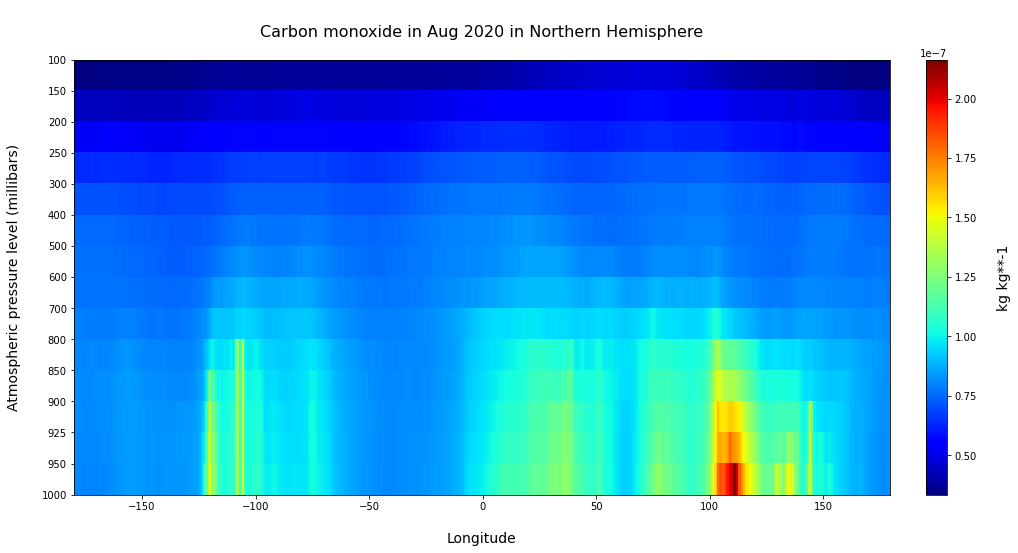

In [52]:
# Define the figure and specify size
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot()

# Plot the figure with pcolormesh
im = plt.pcolormesh(co.longitude, y, co[0,:,:], cmap='jet')

# Set x and y axis tickmarks, labels
ax.yaxis.set_ticks(y)
ax.yaxis.set_ticklabels(co.level.values)

# Set axes labels and title
ax.set_xlabel('\nLongitude', fontsize=14)
ax.set_ylabel('Atmospheric pressure level (millibars)\n', fontsize=14)
ax.set_title('\n'+ co.long_name + ' in Aug 2020 in Northern Hemisphere\n', fontsize=16)

# Specify a colorbar
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.set_label('\n'+ co.units, fontsize=14)

The plot above shows you how the concentration and longitudinal distribution of Carbon Monoxide in the northern hemisphere varies at different levels of the atmosphere and at different longitudes. Striking are the elevated Carbon Monoxide values between 100 and 110 degrees East, which is an indicator of the strong industrial activity in China.

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>